In [18]:
import pandas as pd
from shapely.wkt import loads
from shapely.geometry import LineString
import geopandas as gpd
from shapely import wkt
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString
import math



points = pd.read_pickle("Data/points.pkl")
trajs = pd.read_pickle("Data/trajectories.pkl")

points = points.sort_values(by=["trajectory_sid", "timestamp"])
grouped_points = points.groupby("trajectory_sid")["timestamp"].apply(list).reset_index()

heading_df = pd.merge(trajs, grouped_points, left_index=True, right_on="trajectory_sid", how="left")

Passes road section

In [19]:
 #E6 efter angrered
# road_section = LineString([(322169, 6411344), (322081, 6412907)])

# Tingstadstunneln
# road_section = LineString([(320685, 6401583), (320431, 6401919)])

### CONGESTED

#TORPAMOTET - STRAX FÖRE PARTILLEMOTET
# road_section = LineString([(324000.5499657128, 6402303.127069648), (326752.128046, 6402938.658064)])

# Agnesberg
# road_section = LineString([(322108, 6408320), (322143, 6408455)])

# Efter Munkebäcksmotet vid torpamotet
# road_section = LineString([(323509, 6402118), (323445, 6402093)])

#Kallebäcksmotet
# road_section = LineString([(321349, 6397697), (321290, 6397846)])

#Riksväg 40 vid smörgatan
road_section = LineString([(322376, 6396936), (322191, 6397229)])



### FREEFLOW
# Söderleden höger om järnbrottsmotet # Ger ganska flukturerande resultat
# road_section = LineString([(317457, 6393404), (317675, 6393394)])

# Askim vid Otterbäck # Ger stort drop vid 16 medan TV är rätt stadig
# road_section = LineString([(316999, 6390947), (317122, 6390534)])

# Oscarsleden vid Majnabbegatan # Rätt stadig med drop mitt i natten
# road_section = LineString([(316677, 6399129), (316534, 6399076)])

# Åbymotet
# road_section = LineString([(322608, 6392581), (322467, 6392879)])

# E20 innan Jonsered
# road_section = LineString([(330496, 6403701), (330326, 6403656)])





# Convert the road_section to a Shapely LineString object
road_section_line = road_section

# Define the buffer distance (adjust as needed)
buffer_distance = 20.0  # Adjust the buffer distance as needed (in the same units as your coordinates)

# Create a buffered polygon around the road section
buffered_road_section = road_section.buffer(buffer_distance)

def count_cars_passing(trajectory, buffered_road_section):
    try:
        # Convert the trajectory to a Shapely LineString object
        trajectory_line = loads(trajectory)
        
        # Check if the trajectory intersects the buffered road section
        if trajectory_line.intersects(buffered_road_section):
            return 1  # This trajectory intersects the buffered road section
        else:
            return 0  # This trajectory does not intersect the buffered road section
    except:
        pass

heading_df['passes_road_section'] = heading_df['line'].apply(count_cars_passing, buffered_road_section=buffered_road_section)

# Count the total number of cars passing through the buffered road section
total_cars_passing = heading_df['passes_road_section'].sum()
print(f"Total number of cars passing through the buffered road section: {total_cars_passing}")


Total number of cars passing through the buffered road section: 4451


In [20]:
heading_df = heading_df[heading_df["passes_road_section"] == 1].reset_index(drop=True)

heading_df['geometry'] = heading_df['line'].apply(wkt.loads)

# Convert DataFrame to GeoDataFrame
geodf = gpd.GeoDataFrame(heading_df, geometry='geometry')

In [21]:
# Avenyn
# POINT1 = Point(319568, 6399605)
# POINT2 = Point(319603, 6399557)

#Nya alllen
# POINT1 = Point(319568, 6399605)
# POINT2 = Point(319603, 6399557)

# # E6 efter angered
# POINT1 = Point(322169, 6411344)
# POINT2 = Point(322081, 6412907)

# Strax före Agnesberg
# POINT1 = Point(322108, 6408320)
# POINT2 = Point(322143, 6408455)

# Efter Munkebäcksmotet vid torpamotet
# POINT1 = Point(323509, 6402118)
# POINT2 = Point(323445, 6402093)

# Kallebäcksmotet
# POINT1 = Point(321349, 6397697)
# POINT2 = Point(321290, 6397846)

# riksväg 40
POINT1 = Point(322376, 6396936)
POINT2 = Point(322191, 6397229)

# # Söderleden höger om järnbrottet
# POINT1 = Point(317457, 6393404)
# POINT2 = Point(317675, 6393394)

# Askim
# POINT1 = Point(316999, 6390947)
# POINT2 = Point(317122, 6390534)

# Oscarsleden 
# POINT1 = Point(316677, 6399129)
# POINT2 = Point(316534, 6399076)

# Åbymotet
# POINT1 = Point(322608, 6392581)
# POINT2 = Point(322467, 6392879)

# Jonsered
# POINT1 = Point(330496, 6403701)
# POINT2 = Point(330326, 6403656)

def extract_coords_and_time(line, timestamps, point1, point2):
    coords = list(line.coords)

    distance_p1 = [Point(pt).distance(point1) for pt in coords]
    distance_p2 = [Point(pt).distance(point2) for pt in coords]
    # print(distance_p1)
    # print(distance_p2)

    closest_index_p1 = distance_p1.index(min(distance_p1))
    closest_index_p2 = distance_p2.index(min(distance_p2))
    # print(f"close index p1: {closest_index_p1}. Close index p2: {closest_index_p2}")
    # print(f"distance_p1: {min(distance_p1)}. Distance p2 {min(distance_p2)}")

    # Extract the segment between the closest points
    filtered_coords = coords[closest_index_p1:closest_index_p2 + 1]
    filtered_timestamps = timestamps[closest_index_p1:closest_index_p2 + 1]

    if len(filtered_coords) < 2:
        return None, None

    return LineString(filtered_coords), filtered_timestamps


# geodf['filtered_trajectory'] = geodf['geometry'].apply(lambda traj: extract_coords(traj, POINT1, POINT2))
geodf[['filtered_trajectory', 'filtered_timestamps']] = geodf.apply(
    lambda row: extract_coords_and_time(row['geometry'], row['timestamp'], POINT1, POINT2),
    axis=1, result_type="expand")


    

In [22]:
filt_geo = geodf[geodf.filtered_trajectory.notna()].reset_index(drop=True)

# filt_geo.filtered_trajectory.to_csv("e6an.csv", index=False)

In [23]:
import math

def calculate_heading(x1, y1, x2, y2):
    delta_x = x2 - x1
    delta_y = y2 - y1
    theta_rad = math.atan2(delta_x, delta_y)
    theta_deg = math.degrees(theta_rad)
    if theta_deg < 0:
        theta_deg += 360
    return theta_deg

def get_headings(linestring):
    coords = list(linestring.coords)
    # headings = 0
    for i in range(len(coords) - 1):
        x1, y1 = coords[i]
        x2, y2 = coords[i+1]
        heading = calculate_heading(x1, y1, x2, y2)
        # headings.append(heading)
    return heading

# Sample DataFrame with LineString column

filt_geo['headings'] = filt_geo['filtered_trajectory'].apply(get_headings)


In [24]:
# E6an angeredsbron
# heading_df = filt_geo[
#     ((filt_geo['headings'] >= 340) & (filt_geo['headings'] <= 360)) | 
#     ((filt_geo['headings'] >= 160) & (filt_geo['headings'] <= 180))
# ]

# Strax före agnesberg
# heading_df = filt_geo[
#     ((filt_geo['headings'] >= 10) & (filt_geo['headings'] <= 30)) | 
#     ((filt_geo['headings'] >= 190) & (filt_geo['headings'] <= 210))
# ]

# Efter Munkebäcksmotet vid torpamotet
# heading_df = filt_geo[
#     ((filt_geo['headings'] >= 60) & (filt_geo['headings'] <= 80)) | 
#     ((filt_geo['headings'] >= 240) & (filt_geo['headings'] <= 260))
# ]

#Kallebäck
# heading_df = filt_geo[
#     ((filt_geo['headings'] >= 150) & (filt_geo['headings'] <= 170)) | 
#     ((filt_geo['headings'] >= 330) & (filt_geo['headings'] <= 350))
# ]

#riksväg 40
heading_df = filt_geo[
    ((filt_geo['headings'] >= 120) & (filt_geo['headings'] <= 160)) | 
    ((filt_geo['headings'] >= 300) & (filt_geo['headings'] <= 340))
]


### FREEFLOW
# Söderleden järnbrottet
# heading_df = filt_geo[
#     ((filt_geo['headings'] >= 80) & (filt_geo['headings'] <= 100)) | 
#     ((filt_geo['headings'] >= 260) & (filt_geo['headings'] <= 280))
# ]

# Askim vid otterviken
# heading_df = filt_geo[
#     ((filt_geo['headings'] >= 320) & (filt_geo['headings'] <= 340)) | 
#     ((filt_geo['headings'] >= 160) & (filt_geo['headings'] <= 180))
# ]

# Oscarleden
# heading_df = filt_geo[
#     ((filt_geo['headings'] >= 230) & (filt_geo['headings'] <= 250)) | 
#     ((filt_geo['headings'] >= 50) & (filt_geo['headings'] <= 70))
# ]

#Åbymotet
# heading_df = filt_geo[
#     ((filt_geo['headings'] >= 320) & (filt_geo['headings'] <= 340)) | 
#     ((filt_geo['headings'] >= 140) & (filt_geo['headings'] <= 160))
# ]

# Jonsered
# heading_df = filt_geo[
#     ((filt_geo['headings'] >= 60) & (filt_geo['headings'] <= 80)) | 
#     ((filt_geo['headings'] >= 240) & (filt_geo['headings'] <= 260))
# ]


heading_df.filtered_trajectory.to_csv("e6an.csv", index=False)

In [25]:
heading_df.shape

(2025, 14)

In [26]:
heading_df['first_timestamp'] = heading_df['timestamp'].apply(lambda x: x[0] if isinstance(x, list) and x else None)
heading_df['first_timestamp'] = heading_df['first_timestamp'].astype(str)

heading_df['first_timestamp'] = heading_df['first_timestamp'].str.replace("+02:00", "").str.replace("+01:00", "")
heading_df.first_timestamp = pd.to_datetime(heading_df['first_timestamp'])

c:\Users\Timze\AppData\Local\Programs\Python\Python311\Lib\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\Timze\AppData\Local\Programs\Python\Python311\Lib\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\Timze\AppData\Local\Programs\Python\Python311\Lib\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is tryin

In [27]:
# heading_df['first_timestamp'] = heading_df['first_timestamp'].str.rsplit('+', 1).str[0]
# heading_df['first_timestamp'] = pd.to_datetime(heading_df['first_timestamp'])


# plt.figure(figsize=(10, 6))
# plt.plot(hourly_avg_speed['hour'], hourly_avg_speed['speed'], marker='o', linestyle='-')
# plt.xlabel('Hour')
# plt.ylabel('Average Speed')
# plt.title('Average Speed by Hour')
# plt.xticks(hourly_avg_speed['hour'])
# plt.grid(True)
# plt.show()


c:\Users\Timze\AppData\Local\Programs\Python\Python311\Lib\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


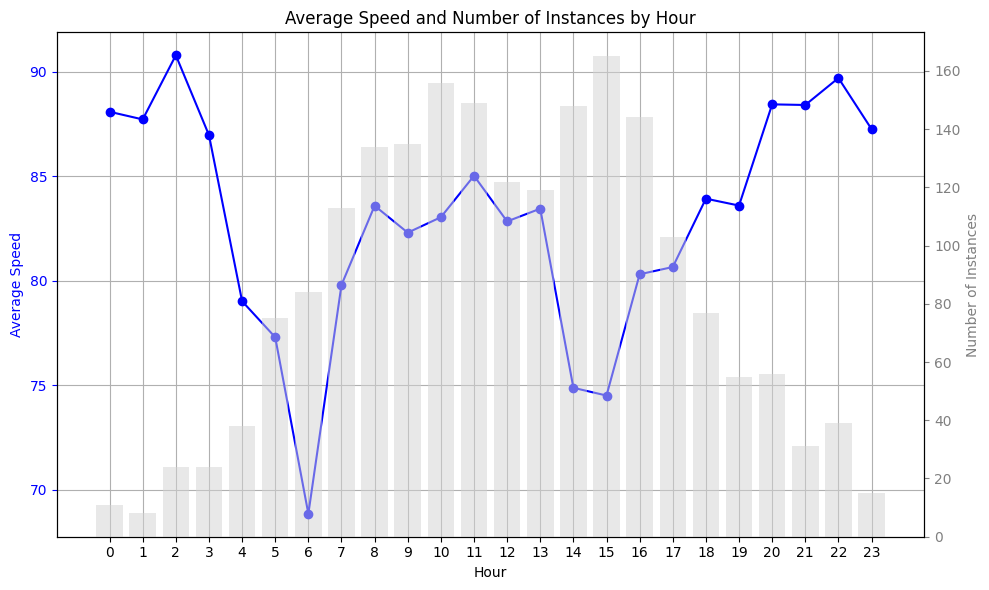

In [28]:

heading_df['hour'] = heading_df['first_timestamp'].dt.hour
hourly_avg_speed = heading_df.groupby('hour')['speed'].mean().reset_index()

hourly_counts = heading_df.groupby('hour').size().reset_index(name='count')


fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot average speed on the left y-axis
ax1.plot(hourly_avg_speed['hour'], hourly_avg_speed['speed'], marker='o', linestyle='-', color='b', label='Average Speed')
ax1.set_xlabel('Hour')
ax1.set_ylabel('Average Speed', color='b')
ax1.tick_params('y', colors='b')
ax1.set_xticks(hourly_avg_speed['hour'])

# Create a second y-axis to plot the number of instances
ax2 = ax1.twinx()
ax2.bar(hourly_counts['hour'], hourly_counts['count'], color='lightgray', alpha=0.5, label='Number of Instances')
ax2.set_ylabel('Number of Instances', color='gray')
ax2.tick_params('y', colors='gray')

# Set title, grid and show the plot
plt.title('Average Speed and Number of Instances by Hour')
ax1.grid(True)
fig.tight_layout()
plt.show()
